**Phase "2.5" running final data against Phase 2 Models---9/6/2019**
**With New Feature Engineering (v2)**

___
Description of Phase 2 contents

**This script takes the best models and features from Phase 1 of the model selection process and undertakes a deeper dive in reviewing/selecting the optimal models.  It also adapts wrangling steps to a Pipeline and embeds that pipeline in the fit_and_evaluate function from Dr. Bengfort's WheatClassification lab.**

To-Do:
- Use balanced sample of 50K observations DONE
- Align features across scripts DONE for outcome variable - PENDING for features (uniformly scale, reformat, normalize as we consolidate code---regularization; BZ)
- Substitute dummies for label encoding, create a pipeline DONE except for two where I need guarateed "1" values
- Add CV with 12 folds and randomized splits DONE
- Review validation curve (PENDING - BZ)
- Precision and Recall - DONE
- Robustness checks for county_type versus MSA binary, state features PENDING - Will do on 8/28 BZ
- Grid search PENDING - Will do on 8/28
- Analyses on all years PENDING - Dependency on wrangling
- Test for collinearity (heat map)
- Updated visuals and single year model validation PENDING
-----
Week of 9/3:
- Holdout sets
- Review learning curve
- Balanced and unbalanced datasets; random-stratifed+random-stratified-balanced
- Sync with Django

In [1]:
%matplotlib inline 

import os
import psycopg2
import json 
import time
import pickle
import pandas as pd 
import seaborn as sns

from sklearn.datasets.base import Bunch
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.exceptions import NotFittedError
from sklearn import metrics

from sklearn.model_selection import StratifiedKFold #ensure allows for randomization
from sklearn.model_selection import train_test_split as tts #drop this if using KFold
from sklearn import preprocessing
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [16]:
con = psycopg2.connect(host="",database="", user="", password="", port="5432")
cur = con.cursor()
cur.execute("SET search_path TO interim_datasets_v2")
query_statement = '''SELECT * FROM hmda_2016_2017_union_srandom_bal_50k_eng;''' 
DATA = pd.read_sql_query(query_statement, con)
DATA.describe(include='all')

,act_outc,action_year,rate_spread,cred_scr_pass_fail_flg,ltv_pass_fail_flg,msa_ent_emb_score,tract_to_msamd_inc,pop,minority_pop_perc,num_owoc_units,...,msamd_nm,lien_status_nm,hoep_status_nm,co_appl_sex,co_appl_race,co_appl_ethn,applic_sex,applic_race,applic_ethn,agency_abbr
count,40909.000000,40909.000000,19290.000000,40909.000000,40909.000000,40909.000000,40909.000000,40909.000000,40909.000000,40909.000000,...,40909,40909,40909,40909,40909,40909,40909,40909,40909,40909
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,408,3,2,5,8,5,4,7,4,6
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Phoenix, Mesa, Scottsdale - AZ",Secured by a first lien,Not a HOEPA loan,No co-applicant,No co-applicant,No co-applicant,Male,White,Not Hispanic or Latino,HUD
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1453,35939,40789,24526,24526,24526,24605,28944,29619,18417
mean,0.471534,2016.504143,2.938625,0.887849,0.999316,0.955467,107.956364,5567.973942,35.995600,1413.174534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.499195,0.499989,1.893684,0.315556,0.026153,0.937136,40.764420,2829.705539,27.639767,774.056715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,2016.000000,1.500000,0.000000,0.000000,0.000000,0.000000,160.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,2016.000000,1.710000,1.000000,1.000000,0.220000,81.060000,3819.000000,12.990000,902.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,2017.000000,2.110000,1.000000,1.000000,0.600000,102.300000,5123.000000,28.110000,1304.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,2017.000000,3.690000,1.000000,1.000000,1.270000,127.700000,6680.000000,54.340000,1784.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
cur.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'interim_datasets_v2'""")
for table in cur.fetchall():
    print(table)

('hmda16_srandom_bal_25k',)
('hmda_2016_2017_union_srandom_bal_50k',)
('interim_hmda_2010_2017_simplerand_balanced200k',)
('hmda_2016_2017_union_srandom_bal_50k_eng',)
('hmda17_srandom_bal_25k',)


In [18]:
cur.close()
con.close()

In [19]:
#Drop rate_spread and msamd_nm

remove = ['rate_spread',
          'state_abbr',
        'msamd_nm']

categorical = ['property_type_nm', 
            'own_occ_nm', 
            'lien_status_nm', 
            'hoep_status_nm', 
            'co_appl_sex', 
            'co_appl_race', 
            'co_appl_ethn', 
            'applic_sex', 
            'applic_race', 
            'applic_ethn', 
            'agency_abbr'
            ]

non_bool_numeric = ['action_year', 
                    'tract_to_msamd_inc', 
                    'pop', 
                    'minority_pop_perc', 
                    'num_owoc_units', 
                    'num_1to4_fam_units', 
                    'ln_amt_000s', 
                    'hud_med_fm_inc', 
                    'applic_inc_000s'
                    ]

In [20]:
DATA = DATA.drop(remove, axis=1)
X = DATA[[col for col in DATA.columns if col != 'act_outc']]
y = DATA['act_outc']

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40909 entries, 0 to 40908
Data columns (total 23 columns):
action_year               40909 non-null int64
cred_scr_pass_fail_flg    40909 non-null int64
ltv_pass_fail_flg         40909 non-null int64
msa_ent_emb_score         40909 non-null float64
tract_to_msamd_inc        40909 non-null float64
pop                       40909 non-null int64
minority_pop_perc         40909 non-null float64
num_owoc_units            40909 non-null int64
num_1to4_fam_units        40909 non-null int64
ln_amt_000s               40909 non-null int64
hud_med_fm_inc            40909 non-null int64
applic_inc_000s           40909 non-null int64
property_type_nm          40909 non-null object
own_occ_nm                40909 non-null object
lien_status_nm            40909 non-null object
hoep_status_nm            40909 non-null object
co_appl_sex               40909 non-null object
co_appl_race              40909 non-null object
co_appl_ethn              40909 n

In [22]:
filepath = os.path.abspath(os.path.join( "..", "fixtures", "testdataphase2_5.csv"))
DATA.to_csv(filepath, index=False)

In [23]:
print(DATA.shape)
print(X.shape)
DATA.describe(include='all')

(40909, 24)
(40909, 23)


,act_outc,action_year,cred_scr_pass_fail_flg,ltv_pass_fail_flg,msa_ent_emb_score,tract_to_msamd_inc,pop,minority_pop_perc,num_owoc_units,num_1to4_fam_units,...,own_occ_nm,lien_status_nm,hoep_status_nm,co_appl_sex,co_appl_race,co_appl_ethn,applic_sex,applic_race,applic_ethn,agency_abbr
count,40909.000000,40909.000000,40909.000000,40909.000000,40909.000000,40909.000000,40909.000000,40909.000000,40909.000000,40909.000000,...,40909,40909,40909,40909,40909,40909,40909,40909,40909,40909
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,3,2,5,8,5,4,7,4,6
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Owner-occupied as a principal dwelling,Secured by a first lien,Not a HOEPA loan,No co-applicant,No co-applicant,No co-applicant,Male,White,Not Hispanic or Latino,HUD
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36139,35939,40789,24526,24526,24526,24605,28944,29619,18417
mean,0.471534,2016.504143,0.887849,0.999316,0.955467,107.956364,5567.973942,35.995600,1413.174534,1915.446161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.499195,0.499989,0.315556,0.026153,0.937136,40.764420,2829.705539,27.639767,774.056715,961.551460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,2016.000000,0.000000,0.000000,0.000000,0.000000,160.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,2016.000000,1.000000,1.000000,0.220000,81.060000,3819.000000,12.990000,902.000000,1299.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,2017.000000,1.000000,1.000000,0.600000,102.300000,5123.000000,28.110000,1304.000000,1768.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,2017.000000,1.000000,1.000000,1.270000,127.700000,6680.000000,54.340000,1784.000000,2352.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
meta = {
    'target_names': [str(yi) for yi in y.unique()],
    'feature_names': list(X.columns),
    'categorical_features': {
        column: list(X[column].unique())
        for column in X.columns
        if X[column].dtype == 'object'
    },
}

with open('data/meta.json', 'w') as f:
     json.dump(meta, f, indent=2)

In [25]:
def load_data(root=os.getcwd()):
    # Construct the `Bunch` for the HMDA dataset
    filenames     = {
        'meta': os.path.join(root, 'data','meta.json'),
        'rdme': os.path.join("..",'readme.md'),
        'data': os.path.abspath(os.path.join( "..", "fixtures", "testdataphase2_5.csv")),
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
    dataset = pd.read_csv(filenames['data'], low_memory=False)

    # Extract the target from the data
    data = dataset[[col for col in DATA.columns if col != 'act_outc']]
    target = dataset['act_outc']

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        categorical_features = meta['categorical_features'], 
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print(dataset.data.shape)

(40909, 23)


From Dr. Bengfort's Census Notebook:

Now that we've finally acheived our feature extraction, we can continue on to the model build phase. To create our classifier, we're going to create a [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that uses our feature transformers and ends in an estimator that can do classification. We can then write the entire pipeline object to disk with the `pickle`, allowing us to load it up and use it to make predictions in the future. 

A pipeline is a step-by-step set of transformers that takes input data and transforms it, until finally passing it to an estimator at the end. Pipelines can be constructed using a named declarative syntax so that they're easy to modify and develop. Our pipeline is as follows:

In [26]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X

**Create Pipeline**

In [27]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, non_bool_numeric),
        ('cat', categorical_transformer, categorical)])

In [28]:
preprocessor.fit_transform(dataset.data).shape

(40909, 58)

**Test Pipeline**

In [29]:
X = dataset.data
y = dataset.target

In [30]:
#Create a list object to eventually make the below cells iteratable
models = [
    GaussianNB(), 
    BernoulliNB(),
    tree.DecisionTreeClassifier(),
    LinearDiscriminantAnalysis(),
    LogisticRegression(solver='lbfgs', max_iter=6000), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100),
    LinearSVC(max_iter=6000),
    SGDClassifier()
]

In [31]:
def fit_and_evaluate(X, y, model, label, **kwargs):

    start  = time.time() # Start the clock! 
    #scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}

    scores = {'precision':[], 'precision_1':[], 'precision_0':[], 'recall':[], 'recall_1':[], 'recall_0':[], 'accuracy':[], 'f1':[],  'f1_1':[],  'f1_0':[]}
    
    skf = StratifiedKFold(n_splits = 12, shuffle=True, random_state=1)
    
    for train, test in skf.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y[train], y[test]
        
        estimator = Pipeline(steps=[('preprocessor', clone(preprocessor)),
                      ('model', model(**kwargs))])
        
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        cr = classification_report(y_test, predicted, output_dict=True)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['precision_1'].append(cr['1']['precision'])
        scores['precision_0'].append(cr['0']['precision'])
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['recall_1'].append(cr['1']['recall'])
        scores['recall_0'].append(cr['0']['recall'])
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))
        scores['f1_1'].append(cr['1']['f1-score'])
        scores['f1_0'].append(cr['0']['f1-score'])
        
    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = Pipeline(steps=[('preprocessor', clone(preprocessor)),
                      ('model', model(**kwargs))])
    estimator.fit(X, y)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [32]:
fit_and_evaluate(X, y, LogisticRegression, "HMDA Logistic Regression", max_iter=6000)

Build and Validation of HMDA Logistic Regression took 14.075 seconds
Validation scores are as follows:

precision      0.684092
precision_1    0.684765
precision_0    0.683491
recall         0.683981
recall_1       0.611144
recall_0       0.748971
accuracy       0.683981
f1             0.682208
f1_1           0.645799
f1_0           0.714696
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-logistic-regression.pickle


In [33]:
fit_and_evaluate(X, y, RandomForestClassifier, "HMDA Random Forest Classifier", n_estimators=100)

Build and Validation of HMDA Random Forest Classifier took 65.786 seconds
Validation scores are as follows:

precision      0.715333
precision_1    0.702323
precision_0    0.726940
recall         0.715515
recall_1       0.688490
recall_0       0.739629
accuracy       0.715515
f1             0.715322
f1_1           0.695292
f1_0           0.733194
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-random-forest-classifier.pickle


In [34]:
fit_and_evaluate(X, y, LinearDiscriminantAnalysis, "HMDA Linear Discriminant Analysis")

Build and Validation of HMDA Linear Discriminant Analysis took 5.639 seconds
Validation scores are as follows:

precision      0.682048
precision_1    0.684898
precision_0    0.679505
recall         0.681708
recall_1       0.601813
recall_0       0.752995
accuracy       0.681708
f1             0.679576
f1_1           0.640620
f1_0           0.714335
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-linear-discriminant-analysis.pickle


In [35]:
fit_and_evaluate(X, y, LinearSVC, "HMDA LinearSVC")

Build and Validation of HMDA LinearSVC took 92.073 seconds
Validation scores are as follows:

precision      0.683441
precision_1    0.685208
precision_0    0.681865
recall         0.683223
recall_1       0.607049
recall_0       0.751192
accuracy       0.683223
f1             0.681285
f1_1           0.643705
f1_0           0.714817
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-linearsvc.pickle


In [36]:
fit_and_evaluate(X, y, BernoulliNB, "HMDA BernoulliNB")

Build and Validation of HMDA BernoulliNB took 2.624 seconds
Validation scores are as follows:

precision      0.651280
precision_1    0.632253
precision_0    0.668257
recall         0.651470
recall_1       0.623533
recall_0       0.676396
accuracy       0.651470
f1             0.651295
f1_1           0.627805
f1_0           0.672255
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-bernoullinb.pickle


In [37]:
fit_and_evaluate(X, y, GaussianNB, "HMDA GaussianNB")

Build and Validation of HMDA GaussianNB took 2.843 seconds
Validation scores are as follows:

precision      0.657160
precision_1    0.762653
precision_0    0.563032
recall         0.583978
recall_1       0.170343
recall_0       0.953049
accuracy       0.583978
f1             0.504353
f1_1           0.276365
f1_0           0.707776
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-gaussiannb.pickle


In [38]:
fit_and_evaluate(X, y, tree.DecisionTreeClassifier, "HMDA DecisionTreeClassifier")

Build and Validation of HMDA DecisionTreeClassifier took 8.061 seconds
Validation scores are as follows:

precision      0.642172
precision_1    0.620142
precision_0    0.661829
recall         0.642059
recall_1       0.621981
recall_0       0.659974
accuracy       0.642059
f1             0.642052
f1_1           0.620992
f1_0           0.660843
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-decisiontreeclassifier.pickle


In [39]:
fit_and_evaluate(X, y, BaggingClassifier, "HMDA BaggingClassifier")     

Build and Validation of HMDA BaggingClassifier took 107.247 seconds
Validation scores are as follows:

precision      0.689323
precision_1    0.690637
precision_0    0.688150
recall         0.689164
recall_1       0.617418
recall_0       0.753181
accuracy       0.689164
f1             0.687470
f1_1           0.651937
f1_0           0.719175
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-baggingclassifier.pickle


In [40]:
fit_and_evaluate(X, y, ExtraTreesClassifier, "HMDA ExtraTreesClassifier", n_estimators=100)

Build and Validation of HMDA ExtraTreesClassifier took 146.567 seconds
Validation scores are as follows:

precision      0.691528
precision_1    0.675513
precision_0    0.705818
recall         0.691682
recall_1       0.666147
recall_0       0.714466
accuracy       0.691682
f1             0.691534
f1_1           0.670751
f1_0           0.710079
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-extratreesclassifier.pickle


In [41]:
fit_and_evaluate(X, y, SGDClassifier, "HMDA SGDClassifier")

Build and Validation of HMDA SGDClassifier took 6.451 seconds
Validation scores are as follows:

precision      0.656787
precision_1    0.644732
precision_0    0.667543
recall         0.648147
recall_1       0.596175
recall_0       0.694520
accuracy       0.648147
f1             0.641372
f1_1           0.606504
f1_0           0.672483
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-sgdclassifier.pickle


https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html

In [42]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

In [43]:
# Encode the categorical data
X = preprocessor.fit_transform(dataset.data)
#y = dataset.target

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

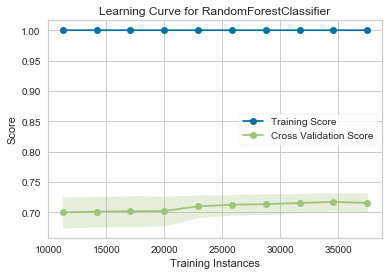

In [44]:
# Instantiate the classification model and visualizer
model = RandomForestClassifier(n_estimators=100)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.poof()           # Draw/show/poof the data

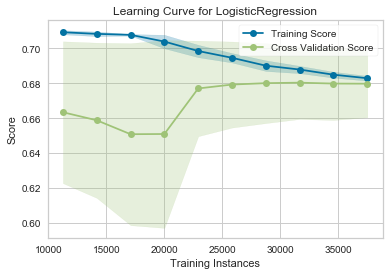

In [45]:
# Instantiate the classification model and visualizer
model = LogisticRegression(max_iter=6000)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.poof()           # Draw/show/poof the data

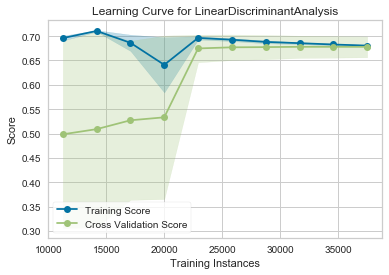

In [46]:
# Instantiate the classification model and visualizer
model = LinearDiscriminantAnalysis()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.poof()           # Draw/show/poof the data

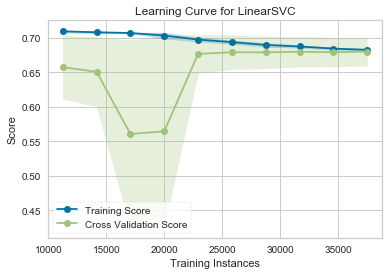

In [47]:
# Instantiate the classification model and visualizer
model = LinearSVC()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.poof()           # Draw/show/poof the data

The last step is to save our model to disk for reuse later, with the `pickle` module:

In [ ]:
import pickle 

def dump_model(model, path='data', name='classifier.pickle'):
    with open(os.path.join(path, name), 'wb') as f:
        pickle.dump(model, f)
        
dump_model(census)

You should also dump meta information about the date and time your model was built, who built the model, etc. But we'll skip that step here, since this post serves as a guide. 

## Model Operation 

Now it's time to explore how to use the model. To do this, we'll create a simple function that gathers input from the user on the command line, and returns a prediction with the classifier model. Moreover, this function will load the pickled model into memory to ensure the latest and greatest saved model is what's being used. 

In [ ]:
def load_model(path='data/classifier.pickle'):
    with open(path, 'rb') as f:
        return pickle.load(f) 


def predict(model, meta=dataset):
    data = {} # Store the input from the user
    
    for column in meta['feature_names'][:-1]:
        # Get the valid responses
        valid = meta['categorical_features'].get(column)
    
        # Prompt the user for an answer until good 
        while True:
            val = " " + input("enter {} >".format(column))
            if valid and val not in valid:
                print("Not valid, choose one of {}".format(valid))
            else:
                data[column] = val
                break
    
    # Create prediction and label 
    yhat = model.predict(pd.DataFrame([data]))
    return yencode.inverse_transform(yhat)
            
    
# Execute the interface 
model = load_model()
predict(model)